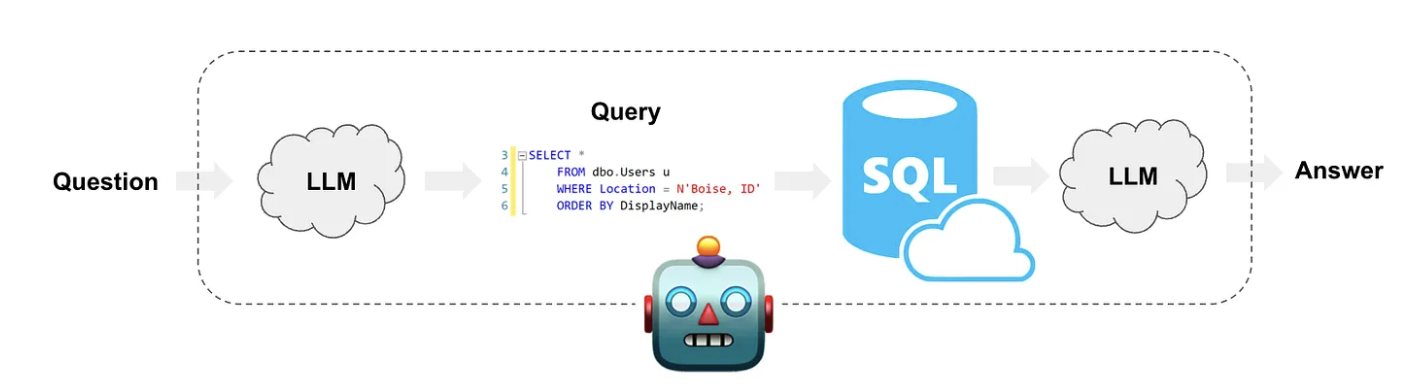

## Install Necessary Libraries

In [2]:
# !pip3 install -qU \
# python-dotenv \
# langchain \
# langchain-core \
# sqlalchemy \
# sqlalchemy-bigquery \
# google-cloud-bigquery \
# langchain-community \
# langchain-ollama \
# pandas \
# db-dtypes \
# langchain-google-genai \ 
# google-generativeai

## Import all environment variables

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()

True

## Fetch the environment Variables

In [7]:
PROJECT_ID = os.getenv("GOOGLE_PROJECT_ID")
DATASET = os.getenv("BIGQUERY_DATASET")
TABLE = os.getenv("BIGQUERY_TABLE")

FULL_TABLE = f"`{PROJECT_ID}.{DATASET}.{TABLE}`"

In [8]:
FULL_TABLE

'`project-de8eda8b-c08d-4034-a53.ecommerce_orders.orders`'

## Give your agent a brain

In [31]:
from langchain_google_genai import ChatGoogleGenerativeAI

def get_llm():
    return ChatGoogleGenerativeAI(
        model="gemini-3-flash-preview",
        temperature=0
    )

## Create Tools

In [27]:
from langchain_core.tools import tool
from langchain_classic.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from google.cloud import bigquery
import pandas as pd
import re

# ---------- INIT ----------
llm = get_llm()
client = bigquery.Client(project=PROJECT_ID)

# ---------- SQL CLEANER ----------
def clean_sql(sql: str) -> str:
    sql = sql.replace("```sql", "").replace("```", "")
    sql = re.sub(r"\bCURRENT_DATE\b(?!\s*\()", "CURRENT_DATE()", sql)
    sql = sql.replace("()()", "()")
    sql = sql.replace("FROM orders", f"FROM {FULL_TABLE}")
    return sql.strip()


# ---------- TOOL 1 : SQL GENERATOR ----------
@tool
def generate_sql(question: str) -> str:
    """Convert user question to BigQuery SQL query"""

    prompt = f"""
You are a BigQuery SQL expert.

Table Name: {FULL_TABLE}
Columns:
order_id INTEGER
customer_id INTEGER
customer_name STRING
city STRING
product_category STRING
amount FLOAT
payment_mode STRING
order_date DATE
delivery_days INTEGER
status STRING

Rules:
- Use ONLY this table
- Revenue column = amount
- Date column = order_date
- BigQuery syntax only
- Return ONLY SQL

Question: {question}
"""

    response = llm.invoke(prompt)

    # GEMINI FIX
    if isinstance(response.content, list):
        sql_text = response.content[0]["text"]
    else:
        sql_text = response.content

    return clean_sql(sql_text)


# ---------- TOOL 2 : RUN QUERY ----------
@tool
def run_bigquery(sql: str) -> str:
    """Execute SQL on BigQuery and return JSON result"""
    df = client.query(sql).to_dataframe()
    return df.to_json(orient="records")

## Create Agent

In [28]:
def create_agent():
    tools = [generate_sql, run_bigquery]

    llm = get_llm()
    llm_with_tools = llm.bind_tools(tools)

    prompt = ChatPromptTemplate.from_messages([
        ("system", """
You are a Data Analyst AI Agent.

Workflow:
1. First call generate_sql
2. Then call run_bigquery
3. Never answer without tools
"""),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(
        llm_with_tools,
        tools,
        prompt
    )

    return AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True
    )


## Run Agent

In [29]:

def runagent(query):
    agent = create_agent()
    response = agent.invoke({
        "input": query
    })
    print("\nFINAL OUTPUT:\n", response["output"])

## Test Agent

In [30]:
runagent("Cities with the highest number of orders")



> Entering new AgentExecutor chain...

Invoking: `generate_sql` with `{'question': 'Cities with the highest number of orders'}`


SELECT
  city,
  COUNT(order_id) AS order_count
FROM
  `project-de8eda8b-c08d-4034-a53.ecommerce_orders.orders`
GROUP BY
  city
ORDER BY
  order_count DESC
Invoking: `run_bigquery` with `{'sql': 'SELECT\n  city,\n  COUNT(order_id) AS order_count\nFROM\n  `project-de8eda8b-c08d-4034-a53.ecommerce_orders.orders`\nGROUP BY\n  city\nORDER BY\n  order_count DESC'}`


[{"city":"Chennai","order_count":160},{"city":"Mumbai","order_count":150},{"city":"Pune","order_count":148},{"city":"Bangalore","order_count":141},{"city":"Hyderabad","order_count":141},{"city":"Kolkata","order_count":135},{"city":"Delhi","order_count":125}][{'type': 'text', 'text': 'The cities with the highest number of orders are:\n\n1.  **Chennai**: 160 orders\n2.  **Mumbai**: 150 orders\n3.  **Pune**: 148 orders\n4.  **Bangalore**: 141 orders\n5.  **Hyderabad**: 141 orders\n6.  **Kolkata**: 135